In [1]:
# Author: Davide Aloi - PhD student - University of Birmingham
# Description: Script to clean T1 / T2 files before running roast simulations. This is 
# necessary as some scans have the cod liver oil, which ROAST segments as skull.
# The script saves a mask called cod_liver_oil.nii which will then be used to remove the
# cod liver oil from the T1s and T2s. The file is saved in each participant's path.


In [2]:
import numpy as np
import nilearn
import os
import glob

main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' 
output_folder = 'D:\\roast-chapter3\\wp_all_results\\' # where to save results
data_folder = 'D:\\roast-chapter3\\'

# Datasets names and subjects lists
db_names = ['wp2a', 'wp1a', 'wp1b']
db_names = ['wp2a']

# list of subjects with cod-liver oil in T1
db_subjects = [['03','04','06','07','08','09','10','11','12','13','15','16','17','18','19','20','22','23','24']]         
db_subjects_t2s = [['03','04','06','07','08','09','10','11','12','13','14','17','18','19','20','22','23','24']]

C:\Users\davide\miniconda3\envs\neuroimg\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
0it [00:00, ?it/s]

D:\roast-chapter3\wp2a\sub-03
Cod liver oil coordinates: (32.71442687747036, 85.28260869565217, 198.03754940711462)


1it [00:13, 13.90s/it]

D:\roast-chapter3\wp2a\sub-04
Cod liver oil coordinates: (34.13894324853229, 111.0518590998043, 206.14187866927594)


2it [00:26, 12.97s/it]

D:\roast-chapter3\wp2a\sub-06
Cod liver oil coordinates: (30.530155642023345, 80.57587548638132, 194.39785992217898)


3it [00:39, 13.02s/it]

D:\roast-chapter3\wp2a\sub-07
Cod liver oil coordinates: (46.377864005912784, 80.39560236511456, 209.1940133037694)


4it [00:52, 12.90s/it]

D:\roast-chapter3\wp2a\sub-08
Cod liver oil coordinates: (34.97331910352188, 70.11953041622199, 195.12593383137673)


5it [01:05, 13.09s/it]

D:\roast-chapter3\wp2a\sub-09
Cod liver oil coordinates: (33.100283822138124, 82.37464522232735, 195.0255439924314)


6it [01:19, 13.35s/it]

D:\roast-chapter3\wp2a\sub-10
Cod liver oil coordinates: (38.44487427466151, 73.93133462282398, 191.36847195357834)


7it [01:31, 13.12s/it]

D:\roast-chapter3\wp2a\sub-11
Cod liver oil coordinates: (41.813025210084035, 94.45588235294117, 207.8046218487395)


8it [01:44, 12.99s/it]

D:\roast-chapter3\wp2a\sub-12
Cod liver oil coordinates: (40.11722731906218, 75.06931702344546, 202.19367991845056)


9it [01:57, 13.02s/it]

D:\roast-chapter3\wp2a\sub-13
Cod liver oil coordinates: (45.736007462686565, 89.34608208955224, 219.59888059701493)


10it [02:09, 12.78s/it]

D:\roast-chapter3\wp2a\sub-15
Cod liver oil coordinates: (33.42909760589318, 75.35543278084714, 203.40055248618785)


11it [02:23, 12.90s/it]

D:\roast-chapter3\wp2a\sub-16
Cod liver oil coordinates: (44.81978452497552, 70.11851126346718, 204.33692458374142)


12it [02:35, 12.65s/it]

D:\roast-chapter3\wp2a\sub-17
Cod liver oil coordinates: (38.034515819750716, 80.2895493767977, 205.9098753595398)


13it [02:46, 12.31s/it]

D:\roast-chapter3\wp2a\sub-18
Cod liver oil coordinates: (43.67631103074141, 100.02712477396021, 217.418324291742)


14it [02:58, 12.00s/it]

D:\roast-chapter3\wp2a\sub-19
Cod liver oil coordinates: (22.877690802348337, 101.74657534246575, 191.06751467710373)


15it [03:10, 12.28s/it]

D:\roast-chapter3\wp2a\sub-20
Cod liver oil coordinates: (36.454819277108435, 71.9136546184739, 198.56927710843374)


16it [03:24, 12.68s/it]

D:\roast-chapter3\wp2a\sub-22
Cod liver oil coordinates: (30.12784090909091, 73.66003787878788, 191.57386363636363)


17it [03:37, 12.90s/it]

D:\roast-chapter3\wp2a\sub-23
Cod liver oil coordinates: (40.763351749539595, 92.3011049723757, 210.38213627992633)


18it [03:52, 13.50s/it]

D:\roast-chapter3\wp2a\sub-24
Cod liver oil coordinates: (32.34110787172012, 82.13216715257532, 201.14091350826044)


19it [04:05, 12.93s/it]


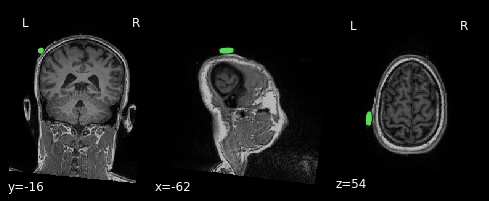

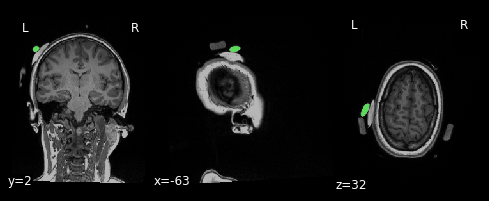

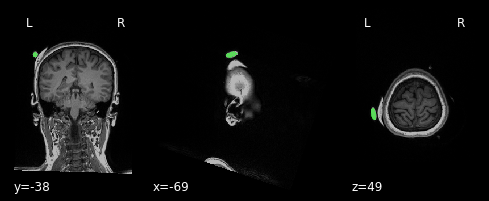

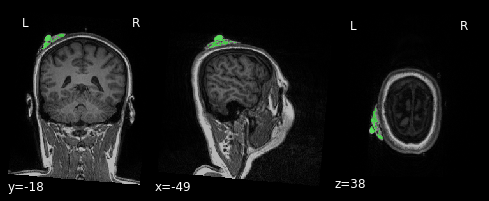

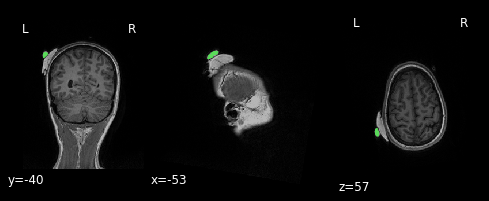

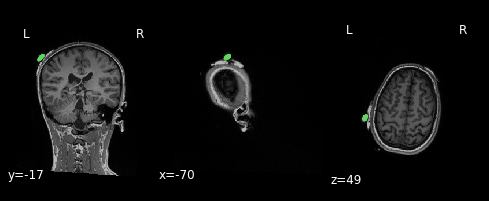

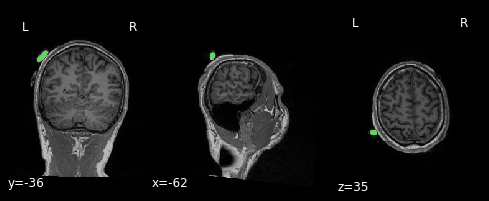

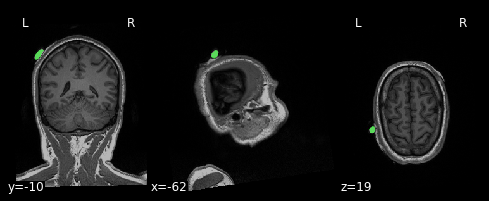

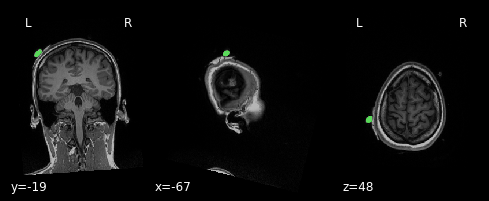

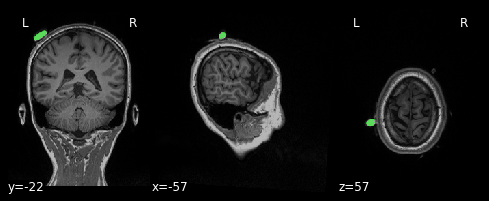

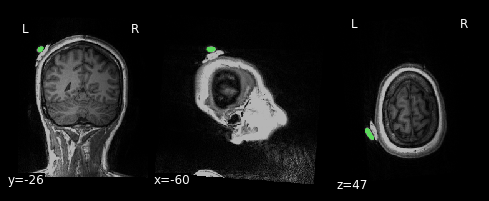

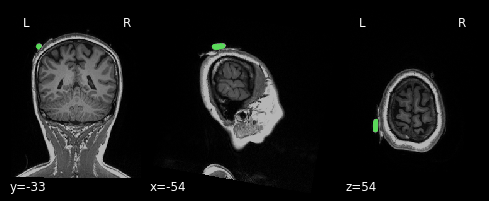

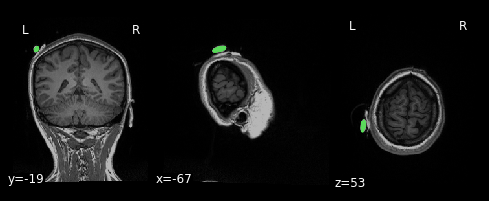

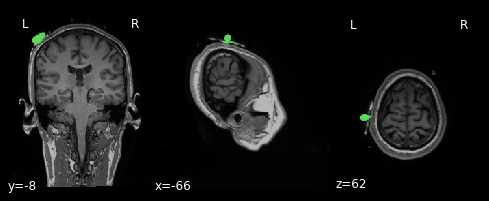

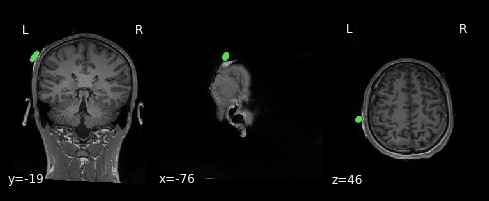

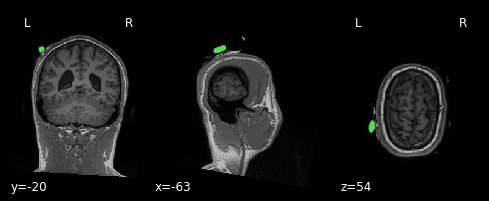

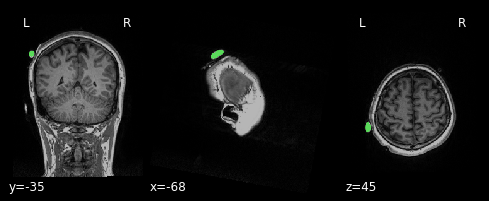

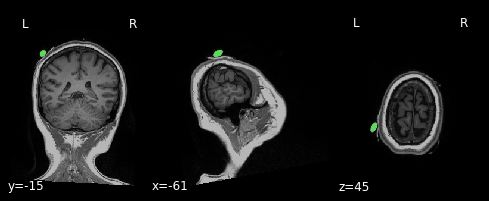

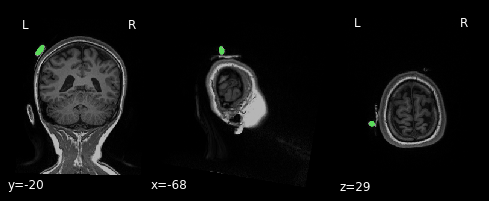

In [3]:
from nilearn import image
from skimage import measure
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
import cupy as cp
from scipy import ndimage
from tqdm import tqdm

for db_id, db in enumerate(db_names): # Iterate all three datasets
    db_path = os.path.join(data_folder, db) # Dataset folder

    for i, subject in tqdm(enumerate(db_subjects[db_id])): #Iterate all subjects
        path = db_path + '\sub-' + subject # Subject folder
        print(path)

        th = 3000 # threshold for binarising T1

        T1 = image.load_img(glob.glob(path + '\sub-*T1.nii'))
        T1_data = T1.get_fdata().reshape(T1.shape[0:3])
        T1 = new_img_like(T1, T1_data)
        T1_bin = np.where(T1.get_fdata() > th, 1, 0)

        # I am masking the part of the scan that I don't need 
        T1_bin[100:208,:,:] = 0
        T1_bin[:,:,0:150] = 0
        T1_bin[:,130:256,:] = 0

        # Clustering
        labels = measure.label(T1_bin, connectivity = 1)
        counts = cp.bincount(cp.asarray(labels[labels>0]))
        idxs = cp.argwhere(cp.asarray(counts>500))[0:8]

        #print('Potential clusters: ' + str(counts[idxs].T))

        # Little trick to find the cod liver oil
        value = 1020 # Value close to the volume of cod liver oil of 7.5 x 7.5 x 13.5 (mm)
        absolute_val_array = np.abs(counts[idxs] - value)
        smallest_difference_index = absolute_val_array.argmin()
        closest_element = idxs[smallest_difference_index]

        # Creating Cod liver oil mask
        T1_bin_clusters = np.where(np.isin(cp.asnumpy(labels), cp.asnumpy(closest_element)), 1, 0)
        cdl = new_img_like(T1, T1_bin_clusters)
        # Cod liver oil coords (to check results)
        peak = ndimage.measurements.center_of_mass(T1_bin_clusters)
        print('Cod liver oil coordinates: ' + str(peak))

        # Coordinate of cod liver oil
        peak_mni = nilearn.image.coord_transform(peak[0],peak[1],peak[2], T1.affine)

        # Plot to check results
        display = plot_anat(T1, cut_coords = peak_mni, draw_cross = False) 
        display.add_overlay(cdl, cmap = 'green_transparent')
        
        # Saving Cod liver oil mask
        cdl.to_filename(os.path.join(path, 'cod_liver_oilT1.nii'))

0it [00:00, ?it/s]

D:\roast-chapter3\wp2a\sub-03
Cod liver oil coordinates: (31.388734995383196, 88.20313942751616, 197.71745152354572)


1it [00:13, 13.92s/it]

D:\roast-chapter3\wp2a\sub-04
Cod liver oil coordinates: (34.3953712632594, 111.43490838958535, 207.4937319189971)


2it [00:27, 14.01s/it]

D:\roast-chapter3\wp2a\sub-06
Cod liver oil coordinates: (31.38489535941765, 79.4786169244768, 194.88898999090082)


3it [00:40, 13.51s/it]

D:\roast-chapter3\wp2a\sub-07
Cod liver oil coordinates: (42.18696581196581, 73.49893162393163, 215.73824786324786)


4it [00:53, 13.17s/it]

D:\roast-chapter3\wp2a\sub-08
Cod liver oil coordinates: (52.888097660223806, 69.80976602238047, 209.7232960325534)


5it [01:06, 13.15s/it]

D:\roast-chapter3\wp2a\sub-09
Cod liver oil coordinates: (33.52652259332024, 84.1385068762279, 194.96267190569745)


6it [01:20, 13.29s/it]

D:\roast-chapter3\wp2a\sub-10
Cod liver oil coordinates: (34.04574565416286, 82.05672461116194, 187.1491308325709)


7it [01:34, 13.62s/it]

D:\roast-chapter3\wp2a\sub-11
Cod liver oil coordinates: (46.19172552976791, 86.99596367305752, 213.58728557013117)


8it [01:46, 13.15s/it]

D:\roast-chapter3\wp2a\sub-12
Cod liver oil coordinates: (30.553587245349867, 89.00620017714792, 192.3852967227635)


9it [01:59, 12.93s/it]

D:\roast-chapter3\wp2a\sub-13
Cod liver oil coordinates: (45.677319587628865, 89.40721649484536, 221.52680412371134)


10it [02:10, 12.34s/it]

D:\roast-chapter3\wp2a\sub-14
Cod liver oil coordinates: (39.033138401559455, 69.99805068226121, 210.41715399610138)


11it [02:22, 12.35s/it]

D:\roast-chapter3\wp2a\sub-17
Cod liver oil coordinates: (36.10978956999085, 69.47209515096066, 200.451967063129)


12it [02:33, 12.01s/it]

D:\roast-chapter3\wp2a\sub-18
Cod liver oil coordinates: (48.273276904474, 100.73397823458284, 225.683192261185)


13it [02:45, 12.02s/it]

D:\roast-chapter3\wp2a\sub-19
Cod liver oil coordinates: (33.63531499556344, 106.29458740017746, 207.63886424134873)


14it [02:56, 11.73s/it]

D:\roast-chapter3\wp2a\sub-20
Cod liver oil coordinates: (42.338427947598255, 78.09170305676857, 207.85152838427948)


15it [03:12, 12.86s/it]

D:\roast-chapter3\wp2a\sub-22
Cod liver oil coordinates: (36.934024505183785, 83.36003770028275, 209.07351555136663)


16it [03:25, 12.95s/it]

D:\roast-chapter3\wp2a\sub-23
Cod liver oil coordinates: (24.87421383647799, 85.2093441150045, 197.5516621743037)


17it [03:38, 12.86s/it]

D:\roast-chapter3\wp2a\sub-24
Cod liver oil coordinates: (32.175438596491226, 82.66471734892788, 202.2972709551657)


18it [03:50, 12.78s/it]


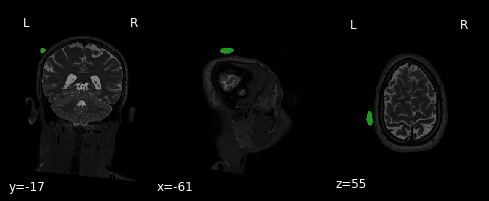

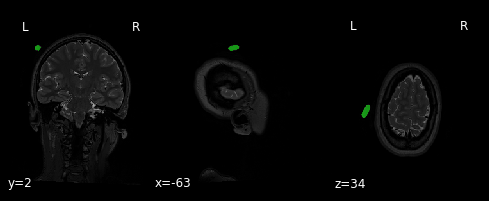

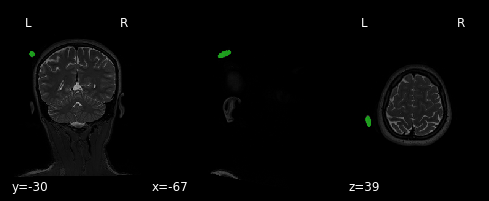

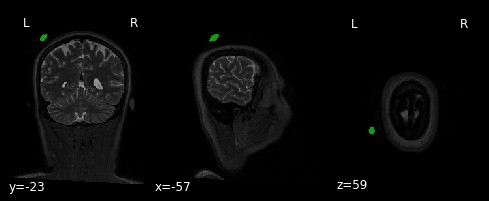

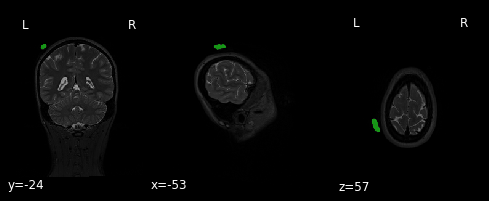

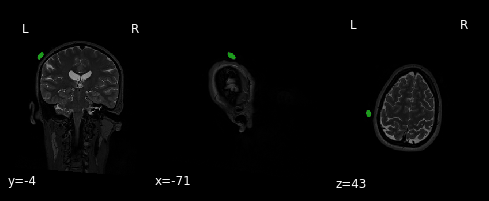

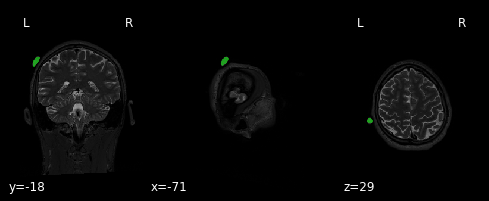

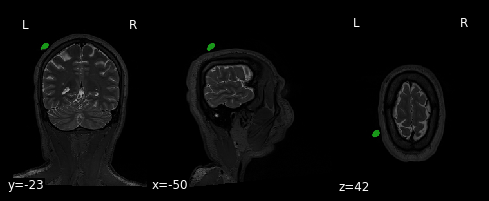

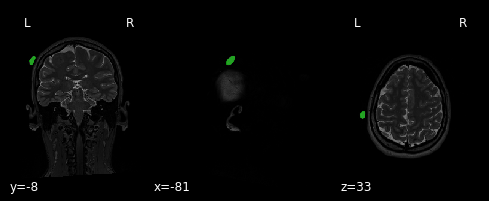

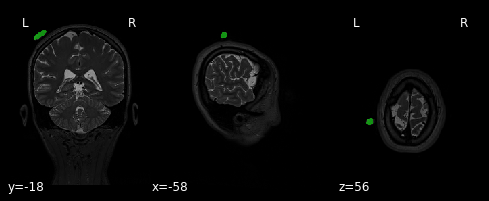

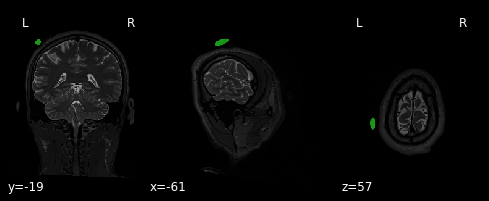

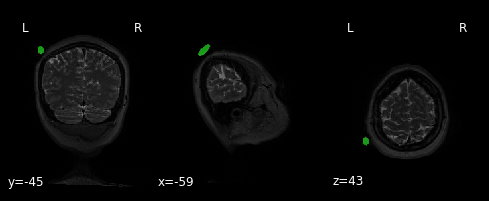

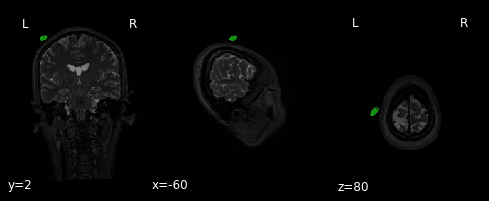

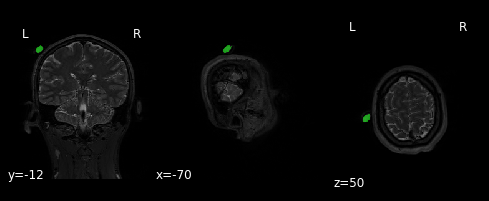

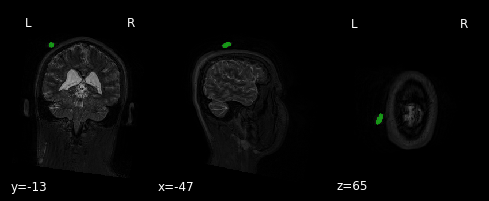

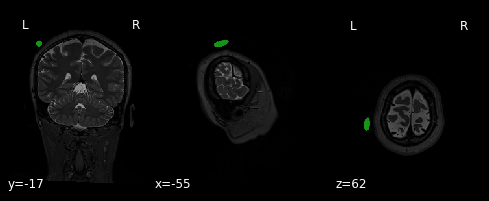

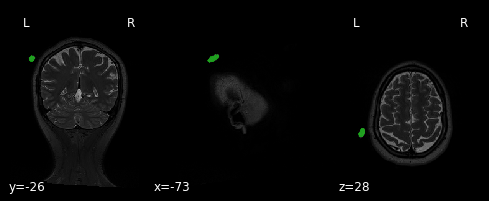

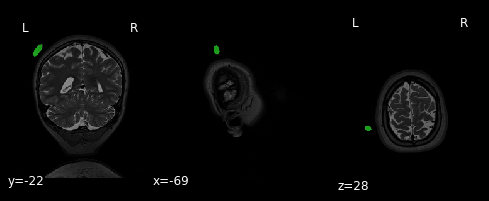

In [4]:
# Same but for T2s
for i, subject in tqdm(enumerate(db_subjects_t2s[db_id])): #Iterate all subjects
        path = db_path + '\sub-' + subject # Subject folder
        print(path)

        th = 200 # threshold for binarising T2

        T2 = image.load_img(glob.glob(path + '\\t2*.nii'))
        T2_data = T2.get_fdata().reshape(T2.shape[0:3])
        T2 = new_img_like(T2, T2_data)
        T2_bin = np.where(T2.get_fdata() > th, 1, 0)

        # I am masking the part of the scan that I don't need 
        T2_bin[100:208,:,:] = 0
        T2_bin[:,:,0:150] = 0
        T2_bin[:,130:256,:] = 0

        # Clustering
        labels = measure.label(T2_bin, connectivity = 1)
        counts = cp.bincount(cp.asarray(labels[labels>0]))
        idxs = cp.argwhere(cp.asarray(counts>500))[0:8]

        #print('Potential clusters: ' + str(counts[idxs].T))

        # Little trick to find the cod liver oil
        value = 1020 # Value close to the volume of cod liver oil of 7.5 x 7.5 x 13.5 (mm)
        absolute_val_array = np.abs(counts[idxs] - value)
        smallest_difference_index = absolute_val_array.argmin()
        closest_element = idxs[smallest_difference_index]

        # Creating Cod liver oil mask
        T2_bin_clusters = np.where(np.isin(cp.asnumpy(labels), cp.asnumpy(closest_element)), 1, 0)
        cdl = new_img_like(T2, T2_bin_clusters)
        
        # Cod liver oil coords (to check results)
        peak = ndimage.measurements.center_of_mass(T2_bin_clusters)
        print('Cod liver oil coordinates: ' + str(peak))
        
        # Coordinate of cod liver oil
        peak_mni = nilearn.image.coord_transform(peak[0],peak[1],peak[2], T2.affine)

        # Plot to check results
        display = plot_anat(T2, cut_coords = peak_mni, draw_cross = False) 
        display.add_overlay(cdl, cmap = 'green_transparent')
        
        # Saving Cod liver oil mask
        cdl.to_filename(os.path.join(path, 'cod_liver_oilT2.nii'))